Demonstrate the use of a densely connected neural network, like the one we trained on the MNIST data set, for classifying stars in the M4 cluster using Gaia's measurements of stars' locations on the sky (right ascension and declination).  This is basically a repeat of what we covered in class, but this time I want you to even out the training set to include roughly equal numbers of M4 members and non-members.

In [1]:
import pandas as pd
import numpy as np

In [2]:
#loaing M4 cluster 
m4_df = pd.read_fwf('../data/NGC6121-1.dat', names=['source_id', 'ra', 'dec', 'phot_g_mean_mag'])
m4_df

,source_id,ra,dec,phot_g_mean_mag
0,6045504229661220736,245.99162,-26.34434,18.438
1,6045504981264184192,246.03035,-26.28057,18.769
2,6045508902585952640,245.88761,-26.24297,19.072
3,6045507180287440000,245.85343,-26.28453,18.495
4,6045503473747038464,245.87124,-26.34628,17.163
...,...,...,...,...
19503,6045337962873610240,245.13976,-27.09970,19.705
19504,6045298891556291712,245.48339,-27.19208,19.493
19505,6045305866578950784,245.69445,-27.06942,18.290
19506,6045303774938119808,245.80824,-27.07275,19.267


In [3]:
import matplotlib.pyplot as plt

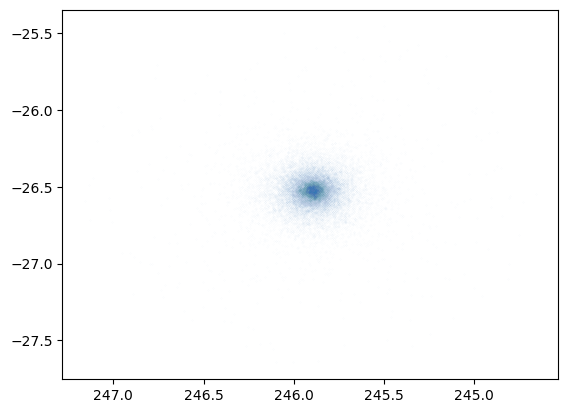

In [4]:
plt.scatter(m4_df.ra, m4_df.dec, s=0.0001)
plt.gca().invert_xaxis()

In [5]:
#M4 cluster using Gaia's measurements of stars' locations on the sky
#3 degree x 3 degree box centered at `RA=246, dec=-26.5`
df = pd.read_csv('../data/m4_gaia_source.csv')

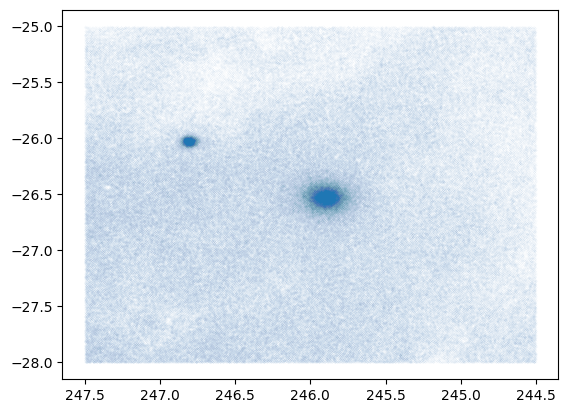

In [6]:
plt.scatter(df.ra, df.dec, s=0.0001)
plt.gca().invert_xaxis()

In [7]:
#classifying cluster members only from Gaia
m4_sel = df['source_id'].isin(m4_df.source_id)
print(np.count_nonzero(m4_sel))

19084


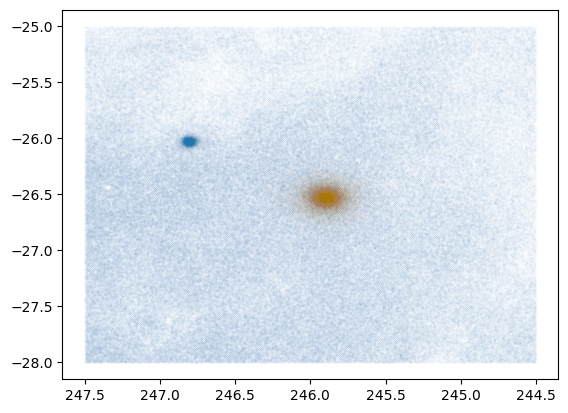

In [8]:
plt.scatter(df.ra[~m4_sel], df.dec[~m4_sel], s=0.0001)
plt.scatter(df.ra[m4_sel], df.dec[m4_sel], s=0.0001)
plt.gca().invert_xaxis()

In [9]:
#checking parameters inside the data to build a classifier based on sky position only
df.columns

Index(['designation', 'source_id', 'ra', 'dec', 'parallax', 'parallax_error',
       'parallax_over_error', 'pm', 'pmra', 'pmra_error', 'pmdec',
       'pmdec_error', 'astrometric_n_good_obs_al', 'astrometric_chi2_al',
       'visibility_periods_used', 'phot_g_mean_flux_over_error',
       'phot_g_mean_mag', 'phot_bp_mean_flux_over_error', 'phot_bp_mean_mag',
       'phot_rp_mean_flux_over_error', 'phot_rp_mean_mag',
       'phot_bp_rp_excess_factor', 'bp_rp', 'radial_velocity',
       'radial_velocity_error'],
      dtype='object')

In [10]:
#Gaia position or features are right ascension (ra) and declination (dec)
params = ['ra', 'dec']
X = np.array(df[params])
X.shape

(494996, 2)

In [11]:
np.count_nonzero(np.any(np.isnan(X), axis=1)) #checking for missing values

0

In [12]:
#when we start adding more columns we might miss values
# If there _were_ missing values, we would remove them like so
nans = np.any(np.isnan(X), axis=1) #identify rows with nan values
X = X[~nans] #remove rows with Nan values

n_classes = 2
y = m4_sel.astype(int)[~nans] #target vector for classification #y contains location of m4 where 1 are members

In [13]:
#normalizing input feature/ standarizing with mean 0

from sklearn.preprocessing import StandardScaler
transformer = StandardScaler()

X = transformer.fit_transform(X)

In [14]:
#using 10% data for testing and rest of them for training
m = X.shape[0]
test_frac = 0.1
test_sel = np.random.choice([True, False], size=m, p=[test_frac, 1-test_frac])
X_tst = X[test_sel]
X_train = X[~test_sel]

y_tst = y[test_sel]
y_train = y[~test_sel]

In [15]:
#balancing member and non-member 

In [16]:
X_m4 = X_train[y_train == 1]
X_non_m4 = X_train[y_train == 0]
y_m4 = y_train[y_train == 1]
y_non_m4 = y_train[y_train == 0]

In [17]:
from sklearn.utils import resample

In [18]:
#reducing number of non members M4
X_non_m4_resampled, y_non_m4_resampled = resample(X_non_m4, y_non_m4, 
                                                  n_samples=X_m4.shape[0],  # Match size of M4 members
                                                  random_state=42)

In [19]:
# Combine the resampled non-members with the M4 members
X_balanced = np.vstack([X_m4, X_non_m4_resampled])
y_balanced = np.hstack([y_m4, y_non_m4_resampled])

In [20]:
X_train = X_balanced
y_train = y_balanced

In [21]:
sum(y_train)

17163

In [22]:
len(y_train)-sum(y_train)

17163

In [23]:
!pip install jax

Defaulting to user installation because normal site-packages is not writeable


In [24]:
import jax
import jax.numpy as jnp

In [25]:
X_train = jnp.array(X_train)
X_tst = jnp.array(X_tst)
y_train = jnp.array(y_train)
y_tst = jnp.array(y_tst)

In [26]:
#neural network design
batch_size = 64
n_batches = X_train.shape[0] // batch_size

X_train = X_train[:n_batches * batch_size].reshape((n_batches, batch_size, *X_train.shape[1:]))
y_train = y_train[:n_batches * batch_size].reshape((n_batches, batch_size, *y_train.shape[1:]))
X_train.shape, y_train.shape

((536, 64, 2), (536, 64))

In [27]:
from flax import linen as nn

In [28]:
#model training
n_classes = 2

class DenseClassifier(nn.Module):
    """A simple dense classifier."""

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(n_classes)(x)
        return x

In [29]:
#summary of the model
dummy_input = jnp.ones((1, 2))
dnn = DenseClassifier()
print(dnn.tabulate(jax.random.PRNGKey(0), dummy_input))


                            DenseClassifier Summary                             
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module          ┃ inputs        ┃ outputs       ┃ params           ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│         │ DenseClassifier │ float32[1,2]  │ float32[1,2]  │                  │
├─────────┼─────────────────┼───────────────┼───────────────┼──────────────────┤
│ Dense_0 │ Dense           │ float32[1,2]  │ float32[1,10] │ bias:            │
│         │                 │               │               │ float32[10]      │
│         │                 │               │               │ kernel:          │
│         │                 │               │               │ float32[2,10]    │
│         │                 │               │               │                  │
│         │                 │               │               │ 30 (120 B)       │
├─────────┼────────────────

In [30]:
#162 trainable parameters

In [31]:
X_train.shape, y_train.shape

((536, 64, 2), (536, 64))

In [32]:
from clu import metrics
from flax.training import train_state
from flax import struct
import optax

In [33]:
#we have 162 trainable parameter
#Training

@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

class TrainState(train_state.TrainState):
   metrics: Metrics

In [34]:
def create_train_state(model, rng, learning_rate):
    params = model.init(rng, dummy_input)['params']
    tx = optax.adam(learning_rate)
    return TrainState.create(
        apply_fn=model.apply, params=params, tx=tx,
        metrics=Metrics.empty())

In [35]:
@jax.jit
def train_step(state, batch, label):
  """Train for a single step."""
  def loss_fn(params):
    logits = state.apply_fn({'params': params}, batch)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=label).mean()
    return loss
  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state

In [36]:
@jax.jit
def compute_metrics(*, state, batch, label):
    logits = state.apply_fn({'params': state.params}, batch)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=label).mean()
    metric_updates = state.metrics.single_from_model_output(
        logits=logits, labels=label, loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [37]:
init_rng = jax.random.PRNGKey(0)

learning_rate = 0.01

state = create_train_state(dnn, init_rng, learning_rate)
del init_rng  # Must not be used anymore.

In [38]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [39]:
X_train

Array([[[-1.808919  ,  0.1227047 ],
        [-1.72282   ,  0.05563187],
        [-1.6916634 , -0.21553771],
        ...,
        [-1.0517815 ,  1.1615813 ],
        [-1.0409784 ,  0.13244858],
        [-1.0375023 ,  1.1112504 ]],

       [[-1.0366919 ,  0.35637525],
        [-1.0351822 , -0.12739237],
        [-1.0276791 , -0.72947615],
        ...,
        [-0.84939027, -0.21096368],
        [-0.8491073 ,  0.3653319 ],
        [-0.84805816,  0.36784488]],

       [[-0.8410351 ,  0.21767984],
        [-0.8365857 ,  0.5984181 ],
        [-0.8332825 ,  0.19301996],
        ...,
        [-0.7633379 ,  1.5117079 ],
        [-0.76266253,  0.16915038],
        [-0.759268  ,  0.17217608]],

       ...,

       [[-1.6185976 ,  0.22280397],
        [ 0.8019798 ,  0.75387263],
        [-1.1337413 ,  0.45272014],
        ...,
        [-0.33887902,  0.15211375],
        [-1.1879141 , -0.24402094],
        [-0.06475005,  0.79822814]],

       [[-0.94813126, -0.57813025],
        [-0.83331615, -0.13

In [40]:
n_epochs = 50

In [41]:
step = 0

for _ in range(n_epochs):
  for batch, label in zip(X_train, y_train):

    # Run optimization steps over training batches and compute batch metrics
    state = train_step(state, batch, label) # get updated train state (which contains the updated parameters)
    state = compute_metrics(state=state, batch=batch, label=label) # aggregate batch metrics

    if (step+1) % n_batches == 0: # one training epoch has passed
      for metric,value in state.metrics.compute().items(): # compute metrics
        metrics_history[f'train_{metric}'].append(value) # record metrics
      state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

      # Compute metrics on the test set after each training epoch
      test_state = state
      test_state = compute_metrics(state=test_state, batch=X_tst, label=y_tst)

      for metric,value in test_state.metrics.compute().items():
        metrics_history[f'test_{metric}'].append(value)

      print(f"train epoch: {(step+1) // n_batches}, "
            f"loss: {metrics_history['train_loss'][-1]}, "
            f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
      print(f"test epoch: {(step+1) // n_batches}, "
            f"loss: {metrics_history['test_loss'][-1]}, "
            f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")
    step += 1

train epoch: 1, loss: 0.1668686866760254, accuracy: 97.56005096435547
test epoch: 1, loss: 0.4283773899078369, accuracy: 96.12044525146484
train epoch: 2, loss: 0.2533971965312958, accuracy: 93.31273651123047
test epoch: 2, loss: 0.39478984475135803, accuracy: 96.12044525146484
train epoch: 3, loss: 0.18267148733139038, accuracy: 94.7994384765625
test epoch: 3, loss: 0.4884296655654907, accuracy: 96.12044525146484
train epoch: 4, loss: 0.22912882268428802, accuracy: 93.1844711303711
test epoch: 4, loss: 0.27978911995887756, accuracy: 96.12044525146484
train epoch: 5, loss: 0.16763918101787567, accuracy: 94.9743423461914
test epoch: 5, loss: 0.6366344094276428, accuracy: 96.12044525146484
train epoch: 6, loss: 0.25655823945999146, accuracy: 95.21630096435547
test epoch: 6, loss: 0.3105516731739044, accuracy: 96.12044525146484
train epoch: 7, loss: 0.17963507771492004, accuracy: 94.39423370361328
test epoch: 7, loss: 0.3481650650501251, accuracy: 96.12044525146484
train epoch: 8, loss: 0

In [42]:
import matplotlib.pyplot as plt

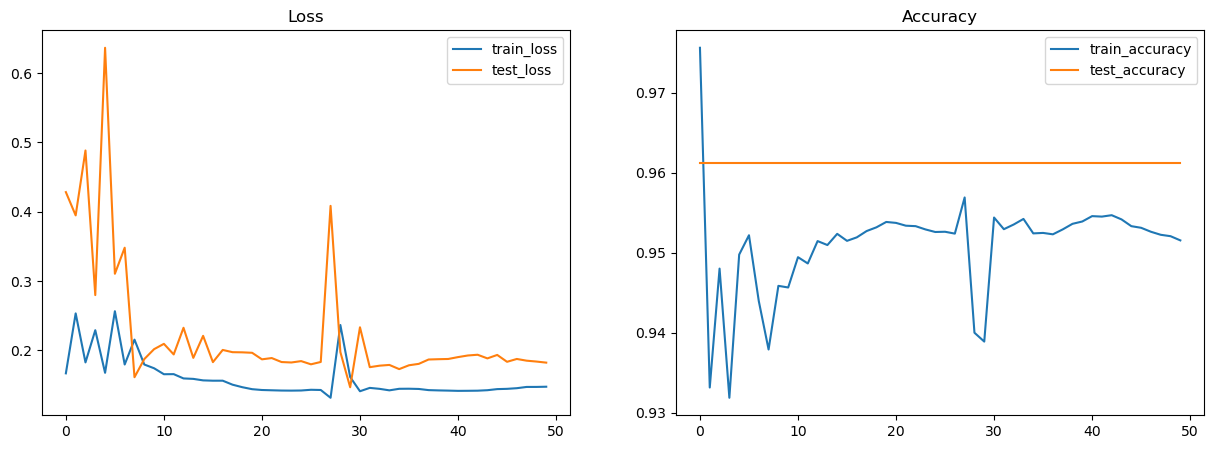

<Figure size 640x480 with 0 Axes>

In [43]:
# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

Q1.What training and validation accuracies are you able to achieve?



Answer: I am getting training accuracy of around 95%. For the validation accuracy, I think we are talking about the test accuracy which is more than 96%. 

Q2. Is your trained model confident that any of the stars in your test set are part of M4? 



Answer: Looking at prediction value which is near 0, it indicated model is confident but model did get distracted because I can see jump in the middle on the graph.

In [44]:
#checking classifier
@jax.jit
def pred_step(state, batch):
  logits = state.apply_fn({'params': state.params}, batch)
  return logits.argmax(axis=1)

pred = pred_step(state, X_tst)
pred

Array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

(array([    0.,     0.,     0.,     0.,     0., 49516.,     0.,     0.,
            0.,     0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

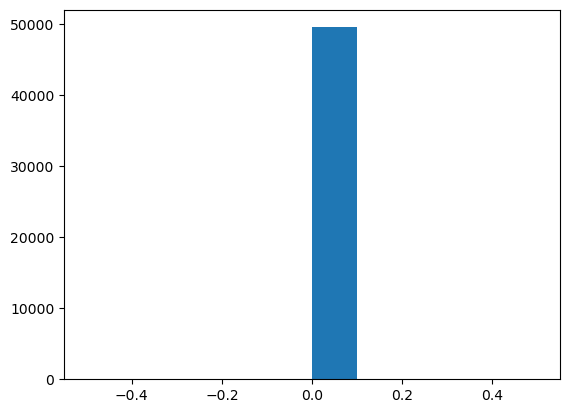

In [45]:
plt.hist(pred)

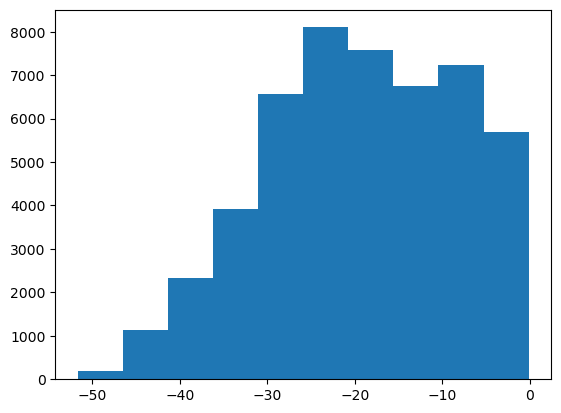

In [46]:
#difference (remember these are "log"its) of the values from the output nodes to see 
# if it's picking up hints of something useful
outputs = state.apply_fn({'params': state.params}, X_tst)
plt.hist(jnp.diff(outputs, axis=1).flatten());

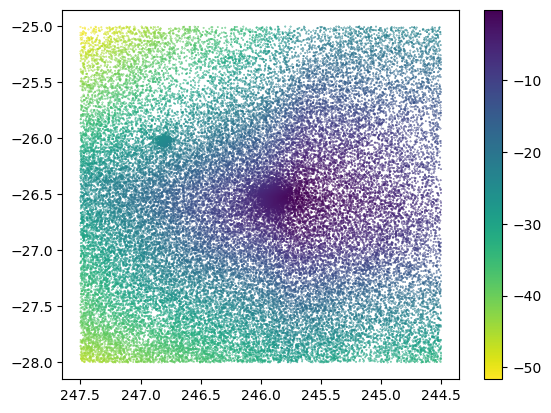

In [47]:
plt.scatter(df.ra[~nans][test_sel], df.dec[~nans][test_sel], c=jnp.diff(outputs, axis=1), s=.1, cmap='viridis_r')
plt.colorbar()

plt.gca().invert_xaxis()

Q3. What did your model learn?  Can you come up with a useful way to probe your model and visualize the results to answer this question?

<function matplotlib.pyplot.show(close=None, block=None)>

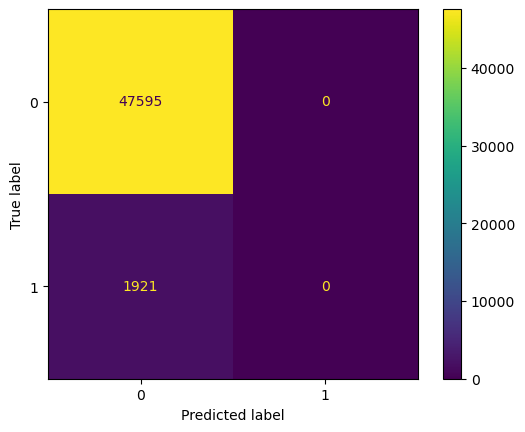

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

M = confusion_matrix(y_tst, pred)

Visualization = ConfusionMatrixDisplay(confusion_matrix=M)
Visualization.plot()
plt.show

Q5. Do you think more sophisticated models could do better with this classification task using only sky positions?  Use the properties of the training set to make your argument.

Answer: Using only sky positions might not give any different results. If we can add features like parallax or some sort of color then we might be able to get more information. We learned about convolution neural network which preserve the spatial (2-D) information of the input images, add a depth to their layers, and reduce the number of connections (and weights). This might give good accuracy if we add new properties.